<center>
    
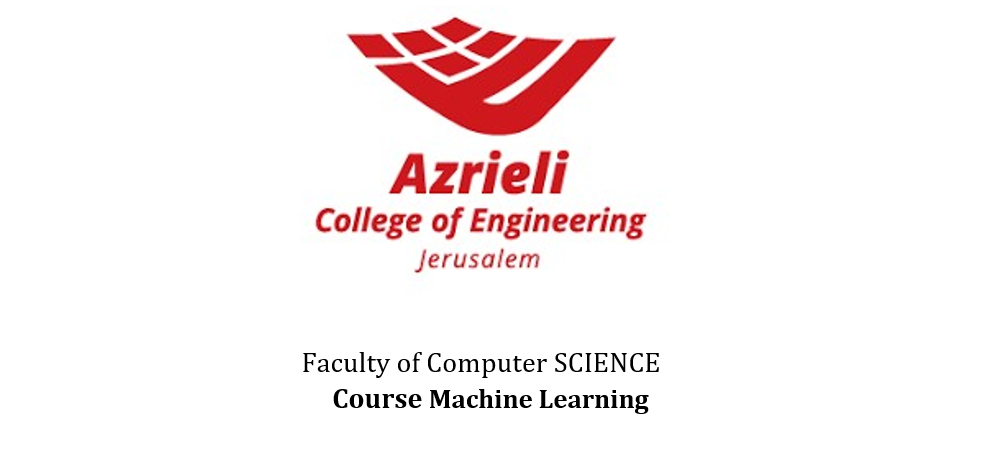


</center>

<hr>
<center><h1><b><u>Ex3 – Final Project – Decision Tree, Random Forest, AdaBoost</u></b></h1>
<hr>
<h1 style="color:blue"><b> Bot or Not? Turing Test for Code: </b></h1> 
<h2>Using Machine Learning to Predict Code Authorship Based on Syntax and Style</h2>
</center>
<hr>
<center>
<h3><u>Submitted by:</u></h3>
    

#### מעיין פקר 200568913    ,    איה יאסין 314630732      ,     גולדה פייגי ברנדווין 337944938

#### chatGPT chat link:   [https://chatgpt.com/share/688a75c6-918c-800b-91fb-513255dde9ae](https://chatgpt.com/share/688a75c6-918c-800b-91fb-513255dde9ae)

</center>
<br>
<hr>

## <u>Objective</u>
<span style="font-size:16px">

    
The objective of this project is to develop and compare three machine learning models <u>implemented from scratch</u>—
* Decision Tree
*  Random Forest
*   and AdaBoost <br>

For the <b>binary classification task of <u>distinguishing AI-generated code from human-written code</u> </b> using the AIGCodeSet dataset.
</span>
<hr>

## <u>Introduction</u>
<span style="font-size:16px"> Recent advances in large language models (LLMs) have enabled automated code generation at scale.<br> However, for applications such as <b>academic integrity, software provenance, plagiarism detection, security,</b> and <b>software quality</b>,<br> <u>it is crucial to reliably detect AI-generated code.</u><br><br>
In this project, we explore the use of machine learning to classify whether a given piece of code was written by a human or generated by an LLM.<br>
We formulated this as a binary classification problem and tested a range of models—including both custom implementations and comparable models from scikit-learn.<br>

Throughout this process, we aimed to identify what approaches work best and understand the unique challenges involved in treating code as data.
</span>
<hr>

## <u>Dataset</u>
<span style="font-size:16px"> 

<b><u>Source:</b></u>
* [https://huggingface.co/datasets/basakdemirok/AIGCodeSet](https://huggingface.co/datasets/basakdemirok/AIGCodeSet) <br>

<b><u>Content:</b></u>
* The AIGCodeSet dataset is a large collection of Python code snippets designed to support research on distinguishing human-written code from code generated by artificial intelligence.
* It contains a total of 7,583 code samples — 4,755 written by humans and collected from IBM’s CodeNet platform, and 2,828 generated by several AI models (Gemini, LLaMA, and Codestral).

<b><u>Features:</b></u>
* The dataset contain several features that were extracted from the raw code by the authors -
  1. Total number of lines.
  2. Number of non-empty code lines.
  3. Number of functions in the code.
  4. Number of blank lines.
  5. Embeddings of the code

* However, we chose to extract features ourselves in order to:
    * Expand the number of features
    * Improve reliability
    * Enhance interpretability and explainability <br>

<b><u> Labels:</b></u>
* The dataset contains labels for each sample, indicating whether human or LLM wrote the code
* The original dataset had several types of LLM produced code:
  1. Generated from scratch
  2. LLM fixed human code with runtime error
  3. LLM fixed human code with syntax error

<b>For simplicity—and in line with our objectives—we focused only on the LLM-generated-from-scratch vs. human-written code.</b>
</span>
<hr>

#### <b><u>Importing the dataset:</b></u>

In [129]:
from datasets import load_dataset

def import_db(dataset_path):
    dataset = load_dataset(dataset_path, split="train") #loading
    dataset = dataset.remove_columns(['problem_id', 'ada_embedding', 'submission_id','lines', 'code_lines', 'comments', 'functions', 'blank_lines']) # Remove unused columns for easier conversion
    return dataset.to_pandas() #return the dataset as pandas dataframe

df = import_db("basakdemirok/AIGCodeSet")

<hr>

## <u>Preprocessing</u>
<span style="font-size:16px"> 

* <b>Cleaning the data </b> - For simplicity, and in line with our objectives—we focused only on the LLM-generated-from-scratch vs. human-written code. Therefore, we filtered the data to match out objectives.
</span>

In [130]:
import numpy as np
human_vs_generated_df = df[np.logical_or(df.status_in_folder == 'Generate', df.label == 0)].reset_index()

<span style="font-size:16px"> 

* <b>re-naming lables</b> - we converted the classes from (1, 0) to (1, -1), mainly to simplify the implementation of our customized AdaBoost model, where:
    * 1: LLM
    * -1: Human
</span>

In [131]:
human_vs_generated_df['label'] = human_vs_generated_df['label'].replace(0, -1)

<span style="font-size:16px"> 
    
* <b>Feature Engineering</b> - Since raw code is hard to feed directly into a classifier, and from reasons mentioned earlier regarding original features from dataset - we extracted a set of handcrafted features from each code snippet. These features reflect various characteristics of the code's structure, style, and content — things that might help distinguish between human and AI-written code. We chose various text based features from our personal experience, and augmented the features with additional features suggested by ChatGPT.
</span>

In [132]:
import pandas as pd
import re
import ast
from spellchecker import SpellChecker
spell = SpellChecker()

def extract_features_from_code(code):
    
    lines = code.split('\n')
    num_lines = len(lines)
    num_comment_lines = sum(1 for line in lines if '#' in line)
    comment_ratio = num_comment_lines / num_lines if num_lines > 0 else 0
    comment_text = ' '.join(re.findall(r'#.*', code))
    comment_words = re.findall(r'\b\w+\b', comment_text.lower())
    misspelled = spell.unknown(comment_words)
    num_misspelled = len(misspelled)
    total_comment_words = len(comment_words)
    misspelling_ratio = num_misspelled / total_comment_words if total_comment_words > 0 else 0

    #Get rid of comments - (makes further regex extractions easier...)
    new_lines = []
    for line in lines:
        new_lines.append(line.split("#")[0]) 
    lines = new_lines
    code = '\n'.join(lines)

    num_blank_lines = sum(1 for line in lines if line.strip() == '')
    num_functions = len(re.findall(r'^\s*def\s', code, re.MULTILINE))
    num_classes = len(re.findall(r'^\s*class\s', code, re.MULTILINE))
    num_loops = len(re.findall(r'\b(for|while)\b', code))
    num_try = len(re.findall(r'\b(try:)\b', code))
    num_conditionals = len(re.findall(r'\b(if|elif|else)\b', code))
    num_imports = len(re.findall(r'^\s*(import|from)\s', code, re.MULTILINE))
    has_main_guard = int('if __name__ == "__main__"' in code)
    num_assignments = len(re.findall(r'^(?!\s*#)\s*\w+\s*=.*$', code, re.MULTILINE))
    avg_line_length = sum(len(line) for line in lines) / num_lines if num_lines > 0 else 0
    indentation_levels = [len(re.match(r'^\s*', line).group(0)) for line in lines if line.strip()]
    max_indent_depth = max(indentation_levels) if indentation_levels else 0
    tab_vs_space = {
        'tabs': sum(1 for line in lines if line.startswith('\t')),
        'spaces': sum(1 for line in lines if line.startswith(' '))
    }
    ends_with_space = sum(1 for line in lines if line.endswith(' '))
    camel_case_count = len(re.findall(r'\b[a-z]+[A-Z][a-zA-Z]*\b', code))  #example - filePath
    snake_case_count = len(re.findall(r'\b[a-z]+(_[a-z]+)+\b', code))      #example - file_path
    has_docstring = int(bool(re.search(r'""".*?"""', code, re.DOTALL)))


    return_type_hints = len(re.findall(r'def\s+\w+\s*\([^)]*\)\s*->\s*[\w\[\], ]+:', code)) #num of function definitions that have return type annotations.
    param_type_hints = len(re.findall(r'def\s+\w+\s*\(([^)]*:\s*[\w\[\], ]+[^)]*)\)\s*(->)?', code))
    generic_names = len(re.findall(r'\b(foo|bar|baz|lorem|ipsum|qux|quux|xyz)\b', code))
    num_prints = len(re.findall(r'(?<!#)[ \t]*print\s*\(', code))
    num_fstrings = len(re.findall(r'''(?<!#)[ \t]*f(['"])(?:\\.|[^\\])*?\1''', code))
    list_comprehensions = len(re.findall(r'\[[^\]]*for\s+\w+\s+in\s+[^\]]+\]', code))


    return {
        'num_lines': num_lines,
        'num_blank_lines': num_blank_lines,
        'num_comment_lines': num_comment_lines,
        'comment_ratio': comment_ratio,
        'num_functions': num_functions,
        'num_classes': num_classes,
        'num_loops': num_loops,
        'num_conditionals': num_conditionals,
        'num_imports': num_imports,
        'has_main_guard': has_main_guard,
        'num_assignments': num_assignments,
        'avg_line_length': avg_line_length,
        'max_indent_depth': max_indent_depth,
        'indent_uses_tabs': tab_vs_space['tabs'],
        'indent_uses_spaces': tab_vs_space['spaces'],
        'ends_with_space':ends_with_space,
        'camel_case_count': camel_case_count,
        'snake_case_count': snake_case_count,
        'has_docstring': has_docstring,
        'num_misspelled': num_misspelled,
        'misspelling_ratio': misspelling_ratio,
        'list_comprehensions':list_comprehensions,
        'num_fstrings':num_fstrings,
        'num_prints':num_prints,
        'generic_names':generic_names,
        'param_type_hints':param_type_hints,
        'return_type_hints':return_type_hints
    }

def extract_features_df(df, code_col='code'):
    features = df[code_col].apply(extract_features_from_code)
    features_df = pd.DataFrame(features.tolist())
    return pd.concat([df, features_df], axis=1), features_df.columns


# the new DF with our new generated features - generated from col 'code' in human_vs_generated_df
df_features, new_features_names = extract_features_df(human_vs_generated_df,'code')

<span style="font-size:16px"> 
    
* <b>Inspecting the data </b> - check for missing values, feature scales, class imbalance (by counting samples per category), observe correlations, and consider removing potentially redundant features.
</span>

* <u>Missing values and data types</u>
    * No missing values to handle
    * all features are numerical

In [133]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5696 non-null   int64  
 1   status_in_folder     5696 non-null   object 
 2   LLM                  5696 non-null   object 
 3   code                 5696 non-null   object 
 4   label                5696 non-null   int64  
 5   num_lines            5696 non-null   int64  
 6   num_blank_lines      5696 non-null   int64  
 7   num_comment_lines    5696 non-null   int64  
 8   comment_ratio        5696 non-null   float64
 9   num_functions        5696 non-null   int64  
 10  num_classes          5696 non-null   int64  
 11  num_loops            5696 non-null   int64  
 12  num_conditionals     5696 non-null   int64  
 13  num_imports          5696 non-null   int64  
 14  has_main_guard       5696 non-null   int64  
 15  num_assignments      5696 non-null   i

* <u>Scaling:</u>
  * Significant differences in feature scales detected – <b>We will normalize the data.</b>

In [134]:
df_features.describe()

,index,label,num_lines,num_blank_lines,num_comment_lines,comment_ratio,num_functions,num_classes,num_loops,num_conditionals,...,snake_case_count,has_docstring,num_misspelled,misspelling_ratio,list_comprehensions,num_fstrings,num_prints,generic_names,param_type_hints,return_type_hints
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,...,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000
mean,4581.038448,-0.669593,22.091643,4.440836,1.197858,0.033907,0.728055,0.018785,2.394136,3.023525,...,2.150632,0.017205,0.741749,0.072641,0.341643,0.024403,1.492451,0.006847,0.015801,0.007900
std,1910.698301,0.742794,23.571162,6.806933,3.819041,0.079342,2.225392,0.166031,2.861085,4.079131,...,6.699059,0.130046,3.147336,0.204676,0.846120,0.189082,1.199771,0.378234,0.194109,0.143115
min,1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3310.750000,-1.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,4734.500000,-1.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6158.250000,-1.000000,28.000000,6.000000,0.000000,0.000000,1.000000,0.000000,3.000000,4.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
max,7582.000000,1.000000,571.000000,144.000000,98.000000,0.764706,50.000000,5.000000,45.000000,103.000000,...,171.000000,1.000000,83.000000,1.000000,11.000000,4.000000,18.000000,28.000000,4.000000,5.000000


In [135]:
#####normlize with Z-score:#####
df_features[new_features_names] = (df_features[new_features_names] - df_features[new_features_names].mean()) / df_features[new_features_names].std()

* <u>Imbalanced data:</u>

    * The data is balanced across different LLM models.
    * However, it is imbalanced between human and LLM-generated code: 4755 vs. 941 samples.
  This imbalance can cause models to become biased toward the majority class, leading to poor performance on the minority class.
      **We will address this by upsampling the minority class (LLM-generated code) through sampling with replacement to equalize class sizes.**

Data is balanced between defferent LLM models


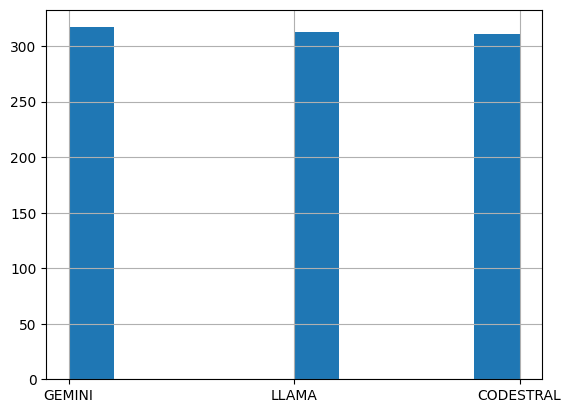

In [136]:
df_features[df_features['LLM'] != 'Human']['LLM'].hist()
print(f"Data is balanced between different LLM models")

<Axes: >

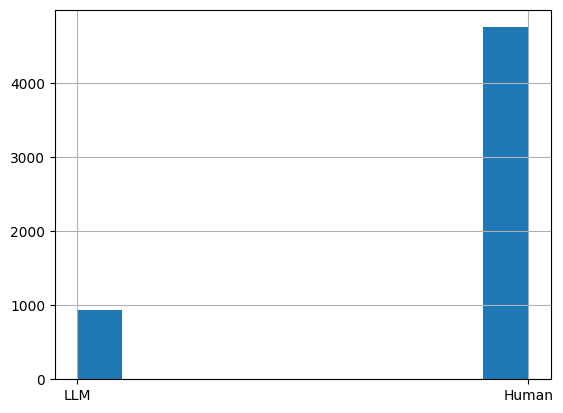

In [137]:
df_features['label'].apply(lambda x: 'Human' if x==-1 else 'LLM').hist()

In [138]:
#####handle  imbalanced data:#####

from sklearn.utils import resample

#returns the most frequent label - in our case its Human(-1)
majority_class = df_features["label"].value_counts().idxmax()

# Separate classes to 2 seperated df's
df_majority = df_features[df_features["label"] == majority_class]
df_minority = df_features[df_features["label"] == -majority_class]

# Oversample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine back
df_balanced = pd.concat([df_majority, df_minority_upsampled])

* <u>Correlated features:</u>
    *  This revealed strong correlations (>=0.85 - that are likely redundant features)
        *  num_comment_lines ↔ num_blank_lines: 0.85
        *  num_lines ↔ indent_uses_spaces: 0.90
    * <b> We decided not to drop - "indent_uses_spaces" and "num_blank_lines" after seeing that it did not improve the results</b>

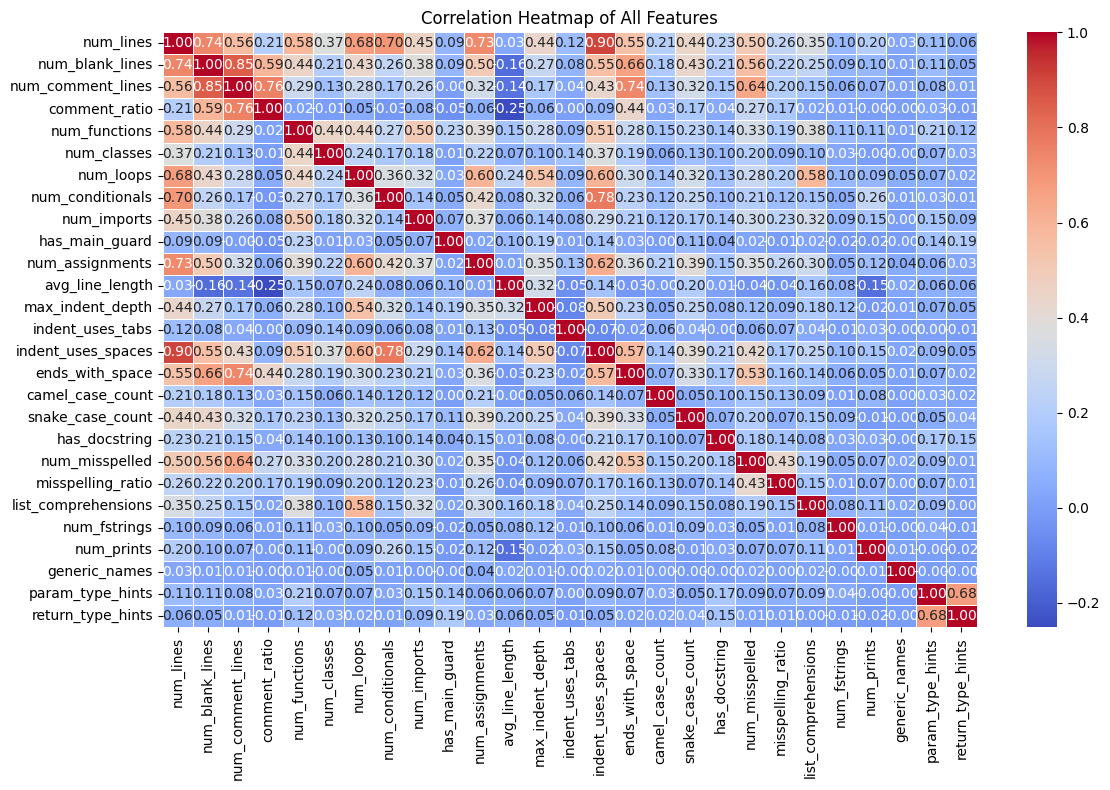

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute correlation matrix
corr = df_balanced[new_features_names].corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of All Features")
plt.tight_layout()
plt.show()

In [141]:
### drop highly correlated features and redundant columns then reset index###
# clean_df = df_balanced.drop(["indent_uses_spaces", "num_blank_lines",'LLM','status_in_folder','index','code'], axis=1).reset_index(drop=True)

#test results without dropping highly correlated columns were better!
clean_df = df_balanced.drop(['LLM','status_in_folder','index','code'], axis=1).reset_index(drop=True)

<hr>

## <u>Sneak peek after Preprocessing</u>

<Axes: >

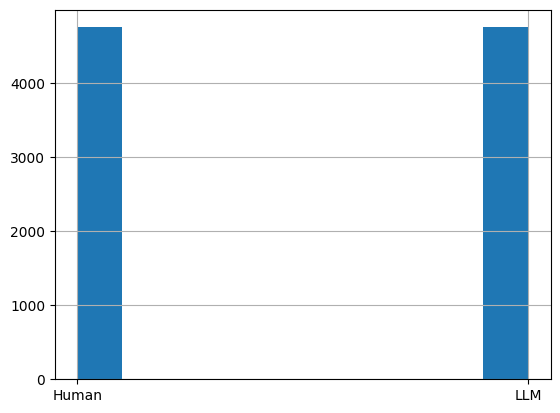

In [142]:
#######check if balanced obtained and check remaining number of observations after preprocess#####
clean_df['label'].apply(lambda x: 'Human' if x==-1 else 'LLM').hist()

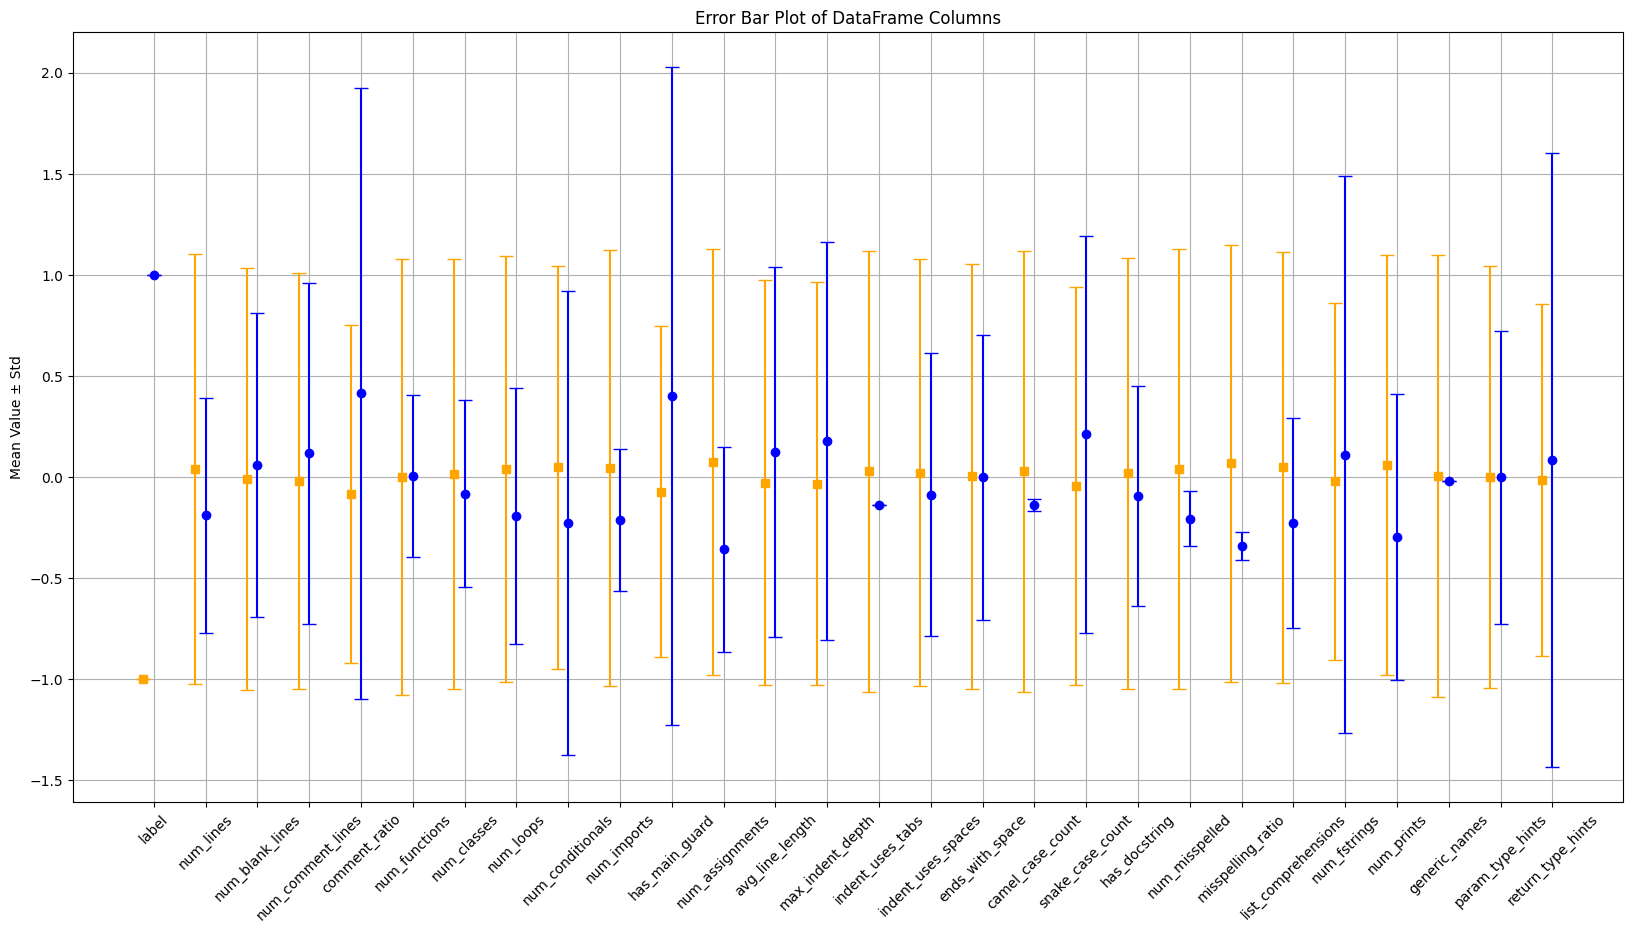

In [143]:
#######check scaling and first notion on how LLM and Human differ in selected features#######
means_llm = clean_df[clean_df['label']==1].mean()
stds_llm = clean_df[clean_df['label']==1].std()
means_human =  clean_df[clean_df['label']==-1].mean()
stds_human = clean_df[clean_df['label']==-1].std()
offset = 0.2

plt.figure(figsize=(20, 10))
x = np.arange(len(means_llm))
plt.errorbar(x=x, y=means_llm.values, yerr=stds_llm.values, fmt='o', capsize=5, linestyle='None', color='blue',label='LLM')
plt.errorbar(x=x - offset, y=means_human.values, yerr=stds_human.values, fmt='s', capsize=5, linestyle='None', color='orange',label='Human')
plt.xticks(ticks=x, labels=means_llm.index, rotation=45)
plt.ylabel("Mean Value ± Std")
plt.title("Error Bar Plot of DataFrame Columns")
plt.grid(True)
plt.show()

In [144]:
##### Show top positive and negative correlations with the target (label) - first notion of feature importance####
corr = clean_df.corr()
label_corr = corr['label'].drop('label')  # drop self-correlation
sorted_corr = label_corr.sort_values(ascending=False)


print("Top features positively correlated with label:")
print(sorted_corr[sorted_corr > 0].head(10))

print("\nTop features negatively correlated with label:")
print(sorted_corr[sorted_corr < 0].tail(10))


Top features positively correlated with label:
comment_ratio        0.199070
has_main_guard       0.179901
snake_case_count     0.128479
max_indent_depth     0.105198
avg_line_length      0.078745
num_comment_lines    0.073579
num_fstrings         0.057093
return_type_hints    0.040887
num_blank_lines      0.039122
num_functions        0.003480
Name: label, dtype: float64

Top features negatively correlated with label:
indent_uses_tabs      -0.108113
num_conditionals      -0.126537
num_lines             -0.132929
num_loops             -0.133022
num_misspelled        -0.157142
num_imports           -0.158286
list_comprehensions   -0.161307
num_prints            -0.195954
num_assignments       -0.252466
misspelling_ratio     -0.258252
Name: label, dtype: float64


<hr>

## <u>Splitting the data to train and test</u>
*  80-20 ratio in train-test

In [145]:
##### Train/test split#####
from sklearn.model_selection import train_test_split

# Separate features and labels
X = clean_df.drop(columns=["label"])
y = clean_df["label"]

# Stratify makes sure the distribution of labels in train and test data is the same.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<hr>

## <u>Models and Algorithms</u>
To tackle the challenge of distinguishing between human-written and LLM-generated code, we implemented and compared several supervised learning models.<br> We used both handcrafted implementations and scikit-learn models to explore the performance and learning behavior of each method.

#### <u>Evaluation and visualizations of the models</u>
* We used standard metrics to evaluate all of our models
* We display a confusion matrix to show where most of the errors are

In [146]:
########evaluation function##########
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#initialize dict of evaluations to view summarized at the end
evaluations = {}

def evaluate_model(y_test,y_pred,model_name):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    #add to evaluation dict 
    evaluations[model_name] = {"Accuracy":accuracy_score(y_test, y_pred),"Precision":precision_score(y_test, y_pred, average='macro'),"Recall": recall_score(y_test, y_pred, average='macro'),"F1 Score": f1_score(y_test, y_pred, average='macro')}
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred))
    disp.plot(cmap='Blues')



### <u>Scikit-learn Decision Tree Classifier</u>
* A decision tree is like a flowchart — a series of yes/no questions that help the model make a prediction.
* During training, the model tries different questions (feature-based splits) and checks how well they separate the data into their true classes.
* This is done using a "loss" function based on impurity metrics such as Entropy and Gini:
    * They measure how mixed or pure each group is after a split.
    * Low impurity means the group contains mostly one class (pure).
    * High impurity means the group contains a mix of classes.
* entropy - for 2 classes:
* what is the probability of class 1* how much it is surprising(the more rare - higher value) + same for second class
* 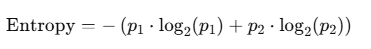
* gini - for 2 classes:
* p^2  is the Probability that both samples are from the same class.
* it calcs The probability that the two samples do not belong to the same class — i.e., they are mixed.
* 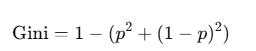

In [147]:
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier_sklearn

def sk_decisionTree(X_train, y_train, max_depth=30, criterion='gini'):
    sk_dt_model = DecisionTreeClassifier_sklearn(criterion=criterion, max_depth=max_depth, random_state=0)
    sk_dt_model.fit(X_train, y_train)
    return sk_dt_model

* <u>Run the function systematically to find best depth:</u>

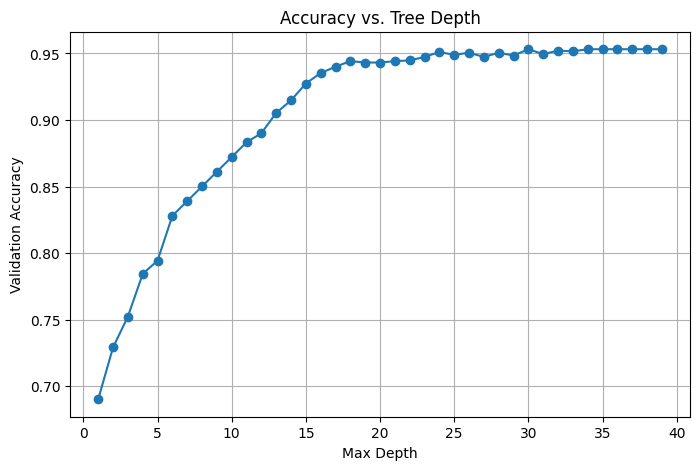


Best depth: 30 with accuracy: 0.9532


In [148]:
from sklearn.metrics import accuracy_score, classification_report
def find_best_depth(X_train, y_train, X_val, y_val, max_depth_range=range(1, 21)):
    from collections import defaultdict
    results = defaultdict(list)
    
    best_depth = None
    best_accuracy = 0

    for depth in max_depth_range:
        depth_model = sk_decisionTree(X_train, y_train,depth)
        y_pred = depth_model.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        results["depth"].append(depth)
        results["accuracy"].append(acc)

        if acc > best_accuracy:
            best_accuracy = acc
            best_depth = depth

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(results["depth"], results["accuracy"], marker='o')
    plt.xlabel("Max Depth")
    plt.ylabel("Validation Accuracy")
    plt.title("Accuracy vs. Tree Depth")
    plt.grid(True)
    plt.show()

    print(f"\nBest depth: {best_depth} with accuracy: {best_accuracy:.4f}")
    return best_depth

best_depth = find_best_depth(X_train, y_train, X_test, y_test, max_depth_range=range(1, 40))


Accuracy: 0.9532071503680336
Precision: 0.9565189788826517
Recall: 0.9532071503680337
F1 Score: 0.95312213119589
Confusion Matrix:
 [[866  85]
 [  4 947]]


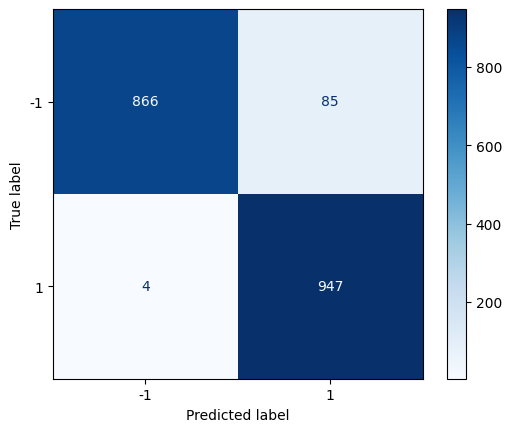

In [149]:
sk_dt_model = sk_decisionTree(X_train, y_train, best_depth)
#Make Predictions
y_pred = sk_dt_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred, "sk_dt_model")

#### <u>Interpretation</u>
* <b>Accuracy</b> - Of all the predictions, 95% were correct.
* <b>Precision</b> - Of all predictions labeled as LLM-generated, 96% were correct.
* <b>Recall</b> - Of all actual LLM-generated samples, 96% were correctly identified by the model.
* <b>F1 Score</b> - A balanced measure of precision and recall. High F1 means the model is both accurate and complete in its predictions.


<b>The model performs very well</b>, with:
* Few mistakes (only 89 total mis-classifications),
* The model is doing better at detecting LLM-generated code — with higher recall and fewer errors.
* It sometimes mistakes Human-written code as LLM-generated, but rarely mistakes LLM code as Human-written.

### <u>Decision Tree Classifier - custom implementation</u>
* We implemented a decision tree classifier from scratch, in a way that it was seamlessly usable by the Random Forest and Adaboost models later defined.
* The base unit of the tree is a TreeNode, which represents a junction in the tree
* The tree is built recursively, from root to leaves, adding TreeNodes on both sides at each recursive step.
* To make the Decision tree class compatible with Adaboost we used weights for measuring impurity:
    * we initially tried to implement an "adaboost" loss function (Weighted error - as used in the stumps example in class). When comparing the performance vs. the sklearn adaboost model, we obtained inferior results, and seeked further guidance on how to correctly implement the tree class which considers the adaboost weights.
    * We tried to solve the issue by resampling the input data, using the adaboost weights as the underlying distribution, but this didn't improve the results.
    * In class, it was mentioned that we need to use the original model's loss function, but to adapt it to consider the weights. Looking through relevant sources in the internet, we realized we need to produce a weighted impurity function, and also to consider the weights in the split gain calculation, and in the majority vote in the leaves level.

In [150]:
# An object that represents a node (junction) in the decision tree.
# If it's a leaf, it holds a value — the predicted classification (e.g., 1 or -1).
class TreeNode:
    def __init__(
        self,
        feature: str,                      # The feature to ask the question about
        threshold: float,                  # The threshold to split the data
        left: "TreeNode",      # The left child node (or class label if it's a leaf)
        right: "TreeNode",     # The right child node (or class label if it's a leaf)
        value: int = None        # The class label if this node is a leaf
    ):
        
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


In [151]:
      
class DecisionTreeClassifier:
    
    #initialize decision tree and its params:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini', max_num_features=None):
        self.tree = None                                  #initializing empty tree. This will later store the root node of the decision tree.
        self.max_depth = max_depth                        #the max depth of the tree -  how many levels of splits (questions) it can go through
        self.max_num_features = max_num_features          #limits the number of features the algorithm considers at each split (for future random forest implementation)
        self.min_samples_split = min_samples_split        #minimum number of data points required to split a node.if a node has fewer samples than this, it becomes a leaf.
        self.criterion = criterion                        #user's choice of loss function
        
        #setting the calc_loss according to user's choice
        if criterion == "entropy":
            self.calc_loss = self.entropy
        elif criterion == "gini":
            self.calc_loss = self.gini
            
        
        
    #function to calculate entropy  - W are weights for adaboost later use
    def entropy(self, y, W=None):
        classes = np.unique(y)                                 # get the labels (-1,1)
        entropy = 0                                            # initialize entropy to 0 (representing purity)
        if W is None:                                          # simple entropy
            for cls in classes:                                # for each class (-1,1) - 
                p_cls = np.sum(y == cls) / len(y)              # calculate percentage - count number of instances and divide by number of observations
                if p_cls > 0:                                  # if class is present in the section - then we need to take it into account for entropy 
                    entropy -= p_cls * np.log2(p_cls)          # this calcs - How likely a class is *  How surprising it is to find it in that section (lower p_cls suggest rare classes and so the log will lead to higher multiplier - it contributes more to the entropy) 
        
        else:                                                  # Weighted entropy - for adaboost use
            W = np.array(W)                                    # Set weights as a NumPy array (easier calculations)
            total_weight = np.sum(W)                           # Total weight of all samples

            if total_weight == 0:                              # Edge case: all weights are zero (All samples are correctly classified with 100% confidence) - entropy is 0 - return (finish)
                return 0
            for cls in classes:                                # for each class (-1,1)
                # Calculate weighted proportion for this class
                class_mask = (y == cls)                        #boolean mask - to get indices of only samples were y labels match for the current class
                weighted_class_count = np.sum(W[class_mask])   #sums the weights only for samples prediction was correct (same as y label)
                p_cls = weighted_class_count / total_weight    #devide that in total weight to get the probability of the class after weights are considered 

                if p_cls > 0:                                  # if class is present in the section - then we need to take it into account for entropy               
                    entropy -= p_cls * np.log2(p_cls)          #same calc as in simple entropy - probability of class * how surprising it is
        return entropy


    
    #function to calculate gini  - W are weights for adaboost later use
    def gini(self, y, W=None):
        classes = np.unique(y)                                # get the labels (-1,1)
        gini = 1                                              # initialize gini to 1 (representing maximum impurity)
        if W is None:                                         # simple gini
            for cls in classes:                               # for each class
                p_cls = np.sum(y == cls) / len(y)             # Count of this class divided by total samples
                gini -= p_cls ** 2                            # subtracts the squared class probabilities. If all samples belong to one class, p_cls = 1, and gini = 0 (pure)
       
        else:                                                 # Weighted gini - for adaboost use
            W = np.array(W)                                   # Set weights as a NumPy array 
            total_weight = np.sum(W)                          # total weights

            if total_weight == 0:                             # that means that All instances were perfectly classified - so we return with pure gini
                return 0

            for cls in classes:                                # for each class (-1,1)
                # Calculate weighted proportion for this class
                class_mask = (y == cls)                        #boolean mask - to get indexes of only samples were y labels match for the current class
                weighted_class_count = np.sum(W[class_mask])   # add their weights
                p_cls = weighted_class_count / total_weight    # divided by the total weight to get the classes probability
                gini -= p_cls ** 2                             # subtracts the squared class probabilities. If all samples belong to one class, p_cls = 1, and gini = 0 (pure)
        return gini
    


    #function to find the best split of all possible splits (using the chosen loss function)
    def best_split(self, X, y, W=None):
        best_gain = 0                 #initilize gain to 0 - How much "better" (purer) the data becomes after a split
        best_feature = None           #initilize what is the best feature to split by
        best_threshold = None         #initilize what is the best threshold (for the best feature) to split by
        loss = self.calc_loss(y, W)   #define the loss function according to the constructor (gini/entropy - as chosen by user)

        n_samples = X.shape[0]         #get number of samples

        #this is fo\r random forest case - if we defined max num of features to choose from - it will randomly pick them
        all_features = X.columns if self.max_num_features is None else np.random.choice(X.columns, size=self.max_num_features, replace=False)
        
        for feature in all_features:                             # iterate each feature
            thresholds = np.unique(X[feature])
            for threshold in thresholds:                         # iterate each possible thresh for each feature
                #devide the samples by <= or > then thresh
                lower_than_thresh = X[feature] <= threshold      
                higher_than_thresh = X[feature] > threshold
                n_lower, n_higher = lower_than_thresh.sum(), higher_than_thresh.sum()
                if n_lower == 0 or n_higher == 0:                # if we didn't create a split (all samples from same class) - it's a bad split just continue to next option
                    continue
                loss_lower = self.calc_loss(y[lower_than_thresh], None if W is None else W[lower_than_thresh])   #calc the loss for the lower than threshold samples (left leaf)
                loss_higher = self.calc_loss(y[higher_than_thresh], None if W is None else W[higher_than_thresh]) #calc the loss for the higher than thresh samples (right leaf)

                #if adaboost - calculate total loss by wighted sum of both sides (multiplying W vector with loss vector)
                if W is not None:
                    total_weight = np.sum(W)
                    weight_lower = np.sum(W[lower_than_thresh])
                    weight_higher = np.sum(W[higher_than_thresh])
                    split_loss = (weight_lower / total_weight) * loss_lower + (weight_higher / total_weight) * loss_higher
                #if not adaboost - calculate total loss by simple sum of both sides
                else:
                    split_loss = (n_lower / n_samples) * loss_lower + (n_higher / n_samples) * loss_higher

                info_gain = loss - split_loss      # the improvement in loss function compared to impurity of the dataset before splitting.

                if info_gain > best_gain:          # if best improvement - this is the current best split
                    best_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain


    
    #recrusive function that build the tree top to bottom - using previous functions of finding the best split
    def build_tree(self, X, y, cur_depth=0, W=None):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        # stop building - if:
                        #we reached max depth or 
                        #pure class division (only 1 label in split) or
                        #number of samples is less the minimum defined to continue splitting
        if (self.max_depth is not None and cur_depth >= self.max_depth) or n_labels == 1 or n_samples < self.min_samples_split:
            value = self.majority_class(y)   #this will return a value (1,-1) meaning we reached a leaf
            return TreeNode(feature=None, threshold=None, left=None, right=None, value=value)

        #get the best split for the current sample
        feature, threshold, gain = self.best_split(X, y, W)

        #if there is no improvement - then stop building that branch... return the class prediction by majority class in the sample
        if gain == 0:
            value = self.majority_class(y)  #this will return a value (1,-1) meaning we reached a leaf
            return TreeNode(feature=None, threshold=None, left=None, right=None, value=value)

        #else - we continue to build... we split the data by the selected feature and threshold
        lower_idx = X[feature] <= threshold
        higher_idx = X[feature] > threshold

        #in case of adaboost - we also send the relevant weights data
        if W is not None:
            W_lower = W[lower_idx]
            W_higher = W[higher_idx]
        else:
            W_lower = W_higher = None

        #we recursively continue to chose best splits for our two new samples - the lower than thresh (left child node) and higher one (right child node)
        lower = self.build_tree(X[lower_idx], y[lower_idx], cur_depth + 1, W_lower)
        higher = self.build_tree(X[higher_idx], y[higher_idx], cur_depth + 1, W_higher)

        #this returns the current tree built up to this point 
        return TreeNode(feature, threshold, lower, higher) 

    
    #function to return majority class in sample
    def majority_class(self, y, W=None):
        # if not adaboost - simple count and return label of max
        if W is None:
            labels, counts = np.unique(y, return_counts=True)
            return labels[np.argmax(counts)]
        else:
            #if adaboost - the "votes" should be counted taking the sample's weight into account
            labels = np.unique(y)
            weighted_counts = []
            for label in labels:                                    #for each class (-1,1)
                weighted_counts.append(np.sum(W[y == label]))       # we calculate the total weight for that class - results are appended to list weighted_counts
            return labels[np.argmax(weighted_counts)]               #we return class of the higher value in weighted_counts


    #function to preform fit (build the tree)
    def fit(self, X, y, W=None):
        if self.max_num_features:                             #in case of random forest - makes sure the max number of features is <= to number of features in X
            assert self.max_num_features<=X.shape[1]
        self.tree = self.build_tree(X, y, W=W)


    
    #function to predict one sample of unseen data (test) - Advancing along the tree until leaf is reached (a node that has a value)
    def predict_sample(self, inputs, node):
        if node.value is not None:
            return node.value
    
        feature = node.feature
        threshold = node.threshold
    
        if inputs[feature] <= threshold:
            return self.predict_sample(inputs, node.left)
        else:
            return self.predict_sample(inputs, node.right)


    #function to predict X matrix - number of samples - each predicted using  predict_sample
    def predict(self, X):
        return np.array([self.predict_sample(inputs[1], self.tree) for inputs in X.iterrows()])    #returns a vectore of predictions


Accuracy: 0.9516298633017876
Precision: 0.9545327583808596
Recall: 0.9516298633017877
F1 Score: 0.9515525102524263
Confusion Matrix:
 [[867  84]
 [  8 943]]


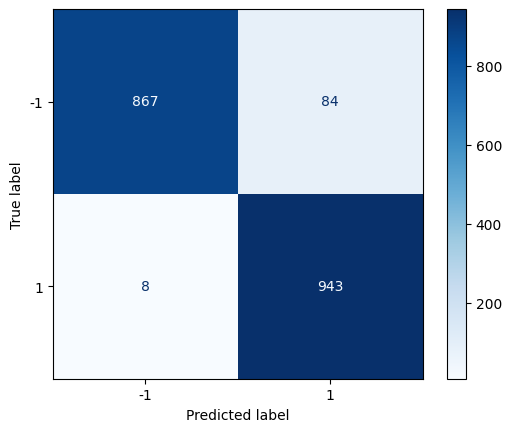

In [152]:
def decisionTree(X_train, y_train, max_depth=30, criterion='gini'):
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

dt_model = decisionTree(X_train, y_train, best_depth)
#Make Predictions
y_pred = dt_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred,"dt_model")

#### <u>Interpretation</u>
* <b>Accuracy</b> - Of all the predictions, 95% were correct.
* <b>Precision</b> – Of all predictions labeled as LLM-generated, 95% were correct. → The model rarely mislabels human-written code as LLM-generated.
* <b>Recall</b> – Of all actual LLM-generated samples, 95% were correctly identified by the model. → The model correctly identifies most of the LLM-generated samples.
* <b>F1 Score</b> – A balanced measure of precision and recall: 95%, which shows the model is both accurate and consistent.
* Only 92 mis-classifications in total (8 + 84)
* The model is very good at catching LLM code (only 8 misses out of 951)
* It sometimes mistakes Human-written code as LLM-generated (84 false positives)
* Overall, the model is well-balanced and highly accurate —yet the previous model performs slightly better across all metrics

<hr>

### <u>Scikit-learn Random Forest</u>
* Random Forest is an ensemble learning method that builds many decision trees and combines their outputs to make better predictions.
* Each tree is trained on a random subset of the data and a random subset of features.
* Random Forest reduces overfitting and improves accuracy by averaging the predictions of many decision trees.
* Random Forest = Many Decision Trees + Randomness + Voting/Averaging = Better Generalization

In [153]:
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier_sklearn

def sk_randomforest(X_train, y_train, n_estimators=30, max_depth=30, max_num_features=5):
    sk_rf_model = RandomForestClassifier_sklearn(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_num_features, 
        n_jobs=-1
    )
    sk_rf_model.fit(X_train, y_train)
    return sk_rf_model


* <u>Run the function systematically to find best depth , number of trees, and number of max featuers:</u>

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 50}
Best Accuracy: 0.9606992639327023
results visualiztion for best max_features 5


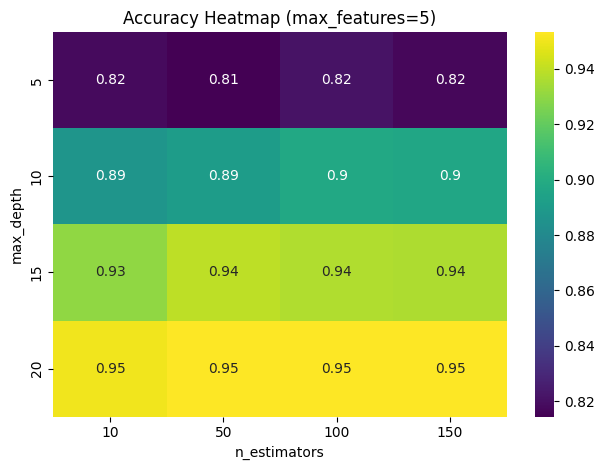

In [154]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [5, 10, 15, 20, None],
    'max_features': [3, 5, 10],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier_sklearn(n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_result = grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)

best_max_features = grid_search_result.best_params_["max_features"]
best_max_depth=grid_search_result.best_params_["max_depth"]
best_n_estimators=grid_search_result.best_params_["n_estimators"]

print(f"results visualiztion for best max_features {best_max_features}")
# Convert CV results to DataFrame
results_df = pd.DataFrame(grid_search_result.cv_results_)

# Filter for fixed max_features
filtered = results_df[results_df['param_max_features'] == best_max_features]

# Pivot table for heatmap
pivot_table = filtered.pivot_table(values='mean_test_score',
                                    index='param_max_depth',
                                    columns='param_n_estimators')

sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title(f"Accuracy Heatmap (max_features={best_max_features})")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()



Accuracy: 0.9695057833859095
Precision: 0.9706068481688158
Recall: 0.9695057833859095
F1 Score: 0.9694879363449692
Confusion Matrix:
 [[899  52]
 [  6 945]]


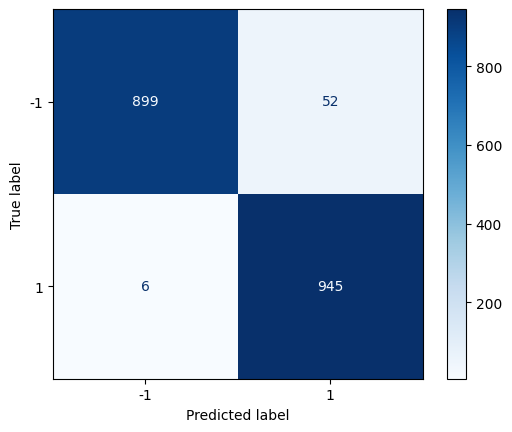

In [155]:
sk_rf_model = sk_randomforest(X_train,y_train, best_n_estimators, best_max_depth, best_max_features)
#Make Predictions
y_pred = sk_rf_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred,"sk_rf_model")

#### <u>Interpretation</u>
* <b>Accuracy</b> - Of all the predictions, 97% were correct.
* <b>Precision</b> –  — When the model predicts a positive class (LLM), it's correct 97% of the time.
* <b>Recall</b> – 97% — The model successfully detects 97.27% of the actual positive cases.
* <b>F1 Score</b> – 97% Balanced combination of precision and recall; excellent performance.
* False Positives (52) slightly higher than False Negatives (6) – the model tends to predict positive more easily, which could be good or bad depending on the domain.
* The overall performance is excellent and very balanced. All four metrics (accuracy, precision, recall, F1) are almost identical and very high.
* Compared to previous result: This new model improved significantly in all metrics.

### <u>Random forest - custom implementation</u>
* Our random forest implementation, is utilizing the basic decision tree class. To allow random trees generation, we implemented
1. Random feature sampling
2. Folding the data, each time sending different samples using sampling with repetitions
* Final decision is based on a majority vote, using only integer tree results, and not probabilities like the sklearn implementation

In [156]:
from scipy.stats import mode
class RandomForestClassifier:
    
    def __init__(self,n_estimators, max_depth=30, criterion='gini',  max_num_features=None, min_samples_split=2):
        #initialize list of trees (n_estimators)
        self.trees=[]
        #insert n trees to that list - each is a DecisionTreeClassifier object from our custom class
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(max_depth, min_samples_split, criterion, max_num_features))


    #fit the model - train the model and build the n trees (the forest) 
    def fit(self, X_train, y_train):
        #for each tree(DecisionTreeClassifier object)  in our n trees - make bootstrap sampling(sample n samples randomly with replacement) - fit the decision tree (build the tree)
        for i,tree in enumerate(self.trees):    
            n_samples = X_train.shape[0]
            sampled_X, sampled_y = resample(X_train, y_train, n_samples=n_samples, random_state=i, stratify=y_train)
            tree.fit(sampled_X, sampled_y)

    #predict using majority vote of n trees
    def predict(self, X):
        all_preds = np.array([tree.predict(X) for tree in self.trees]) 
        majority_vote = mode(all_preds, axis=0)[0]  # scipy.stats returns a special object that contains two arrays - mode and count, thats why [0]
        return majority_vote    

In [157]:
def randomforest(X_train,y_train, n_estimators=30, max_depth=30, max_num_features=5):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,  max_num_features=max_num_features)
    rf_model.fit(X_train, y_train)
    return rf_model

Accuracy: 0.9579390115667719
Precision: 0.960155325567055
Recall: 0.9579390115667719
F1 Score: 0.9578883043732398
Confusion Matrix:
 [[878  73]
 [  7 944]]


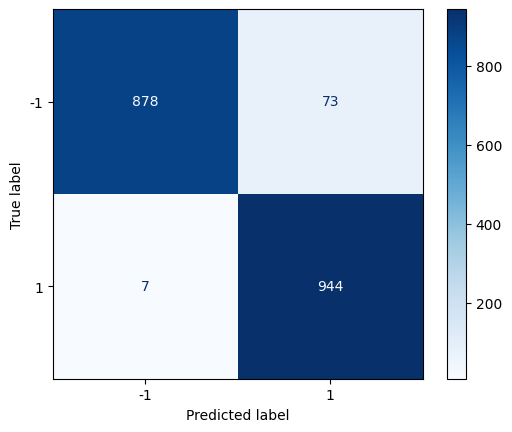

In [158]:
rf_model = randomforest(X_train,y_train, 30,30,6)  #Manual testing revealed the best parameters for this model
#Make Predictions
y_pred = rf_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred,"rf_model")

#### <u>Interpretation</u>
* <b>Precision</b> – 96% — When the model predicts a positive class (LLM), it is correct 95.1% of the time.
* <b>Recall</b> – 96% — The model successfully detects 96% of all actual LLM-generated samples.
* <b>Accuracy</b> – 96% — Very high overall classification correctness.
* <b>F1 Score</b> – 96% — A strong balance between precision and recall, indicating consistent and reliable performance.
* False Positives (73) are more frequent than False Negatives (7) — the model tends to slightly over-predict the positive class.
* Overall, the model performs excellently, with all core metrics (accuracy, precision, recall, F1) tightly grouped and very high.
* Compared to previous results: This model maintains high and balanced performance, though slightly below the previous model’s near-perfect metrics — still a strong and reliable classifier.

<hr>

### <u>Scikit-learn AdaBoost</u>
* AdaBoost is a method for combining many weak models (like shallow decision trees) into a single strong model that makes more accurate predictions.
* Think of it as using a team of experts, where each new expert is recruited to focus on the areas where the team is currently weak.
* Each expert (or model) is given a different weight (or voting power) — experts who perform better get more influence on the final decision.
* The result is a powerful model that learns to handle difficult cases more effectively than any single weak learner.
* AdaBoost has two algorithm modes:
    * SAMME.R (default): Uses predicted probabilities (not just labels); converges faster and usually gives better results.
    * SAMME: Uses only predicted class labels; useful when the base model doesn't support probabilities (predict_proba).

In [159]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoostClassifier_sklearn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def sk_adabbost(X_train,y_train, n_estimators=500, tree_depth=1, random_state=0):
    base_tree = DecisionTreeClassifier_sklearn(max_depth=tree_depth) 
    sk_ab_model = AdaBoostClassifier_sklearn(algorithm='SAMME.R',estimator=base_tree, n_estimators=n_estimators)
    sk_ab_model.fit(X_train, y_train)
    return sk_ab_model

* <u>Run the function systematically to find best model depth and number of models</u>

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'estimator__max_depth': 3, 'n_estimators': 500}
Best Accuracy: 0.9566247739703719


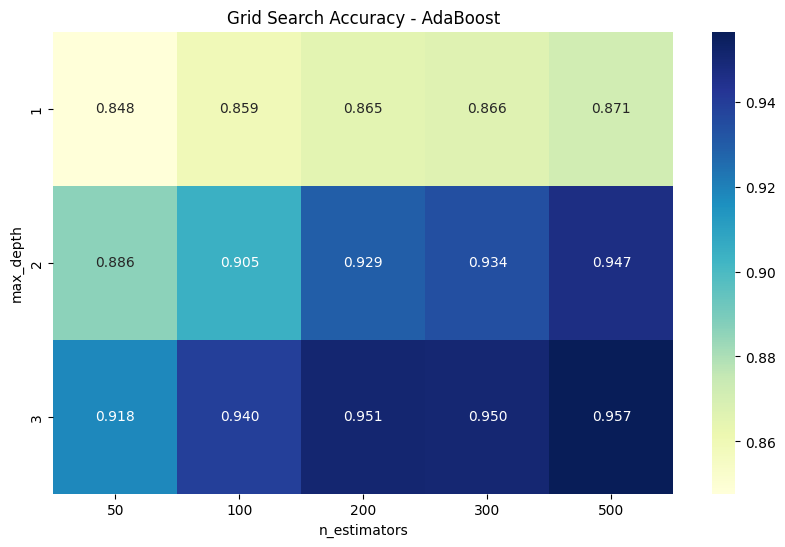

In [160]:
param_grid = {
    'n_estimators': [50,100, 200, 300, 500],
    'estimator__max_depth': [1, 2, 3]
}

model = AdaBoostClassifier_sklearn(estimator=DecisionTreeClassifier_sklearn(), algorithm='SAMME.R')
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_max_depth = grid_search.best_params_["estimator__max_depth"]
best_n_estimators = grid_search.best_params_["n_estimators"]

results = grid_search.cv_results_
df_results = pd.DataFrame(results)
df_results = df_results[['param_n_estimators', 'param_estimator__max_depth', 'mean_test_score']]
df_results.columns = ['n_estimators', 'max_depth', 'accuracy']
pivot_table = df_results.pivot(index='max_depth', columns='n_estimators', values='accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Grid Search Accuracy - AdaBoost")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()


Accuracy: 0.964248159831756
Precision: 0.96610350121725
Recall: 0.964248159831756
F1 Score: 0.9642125465273419
Confusion Matrix:
 [[887  64]
 [  4 947]]


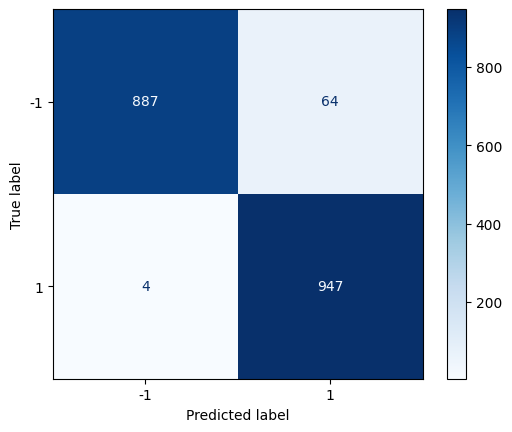

In [161]:
sk_ab_model = sk_adabbost(X_train,y_train, best_n_estimators,best_max_depth)
#Make Predictions
y_pred = sk_ab_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred,"sk_ab_model")

#### <u>Interpretation</u>
* <b>Precision</b> – Of all predictions labeled as positive (e.g., LLM-generated), 97% were correct → The model rarely mislabels human-written code as LLM-generated.
* <b>Recall</b> – Of all actual positive samples, 96% were correctly identified → The model captures nearly all LLM-generated samples.
* <b>F1 Score</b> – A balanced measure of precision and recall: 96%, showing the model is both accurate and consistent.
* <b>Accuracy</b> -  — 96% high overall classification correctness.
* Only 68 misclassifications in total (64 false positives + 4 false negatives).
* The model is excellent at detecting LLM code — only 4 real LLM samples were missed out of 951.
* Occasionally, the model confuses human-written code as LLM-generated (64 cases).
* Overall, the model is highly accurate, precise, and balanced — a strong performer with minimal error. 
* This preformance is slightly less than sklearn random forest

### <u>Adaboost Classifier - custom implementation</u>

* Based on simple decision trees as weak learners, which should have a max_depth of no more than 3 to prevent overfitting on the training data.
* The user can choose the number of weak learners, but if the loss doesn't decrease or the sample weights stop changing, the model will stop adding new learners.
* Additionally, if the loss for the best current learner is 0.5 or more, we stop adding learners, since such a model performs no better than random guessing.
* The final prediction is made based on the selected models and their individual contributions (α values) to the final decision:<br>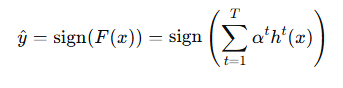
* The model's loss function is the sum of weighted prediction errors:<br> 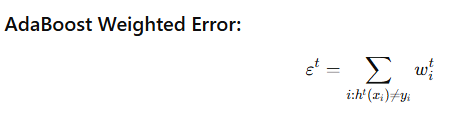
* Alpha (α), or the partial model's influence in the final decision, increases as the model's loss decreases. It is computed as:<br>
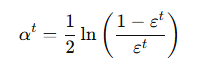 <br>
Note that if the loss is 0.5, α becomes 0 — meaning the model contributes nothing to the final decision.
* Each sample’s weight is updated based on the previous weights and the current model’s performance — misclassified samples receive higher weights:
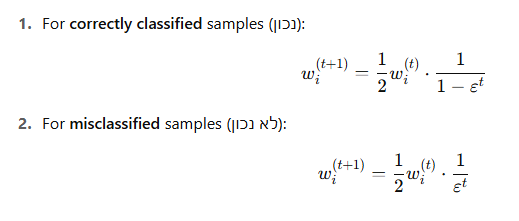
* Finally, note that inside each weak model, the sample weights affect the loss function (e.g., Gini or Entropy) used to train the decision tree.

In [162]:
#loss function for model - sum of weights of bad predictions
def weighted_exponential_loss(y_pred,y,W):
        return (W*(y!=y_pred)).sum()


import math

class AdaBoostClassifier:
    
    def __init__(self,n_estimators, criterion="gini", max_depth=2, min_samples_split=2):
        self.weak_learners=[]             # list of models - weak learners (experts team)
        self.W=None                      # initialize Weights vector
        self.alphas=[]                   # initialize alfa vector
        self.criterion=criterion         # user's chosen criterion for eak learner's loss function

        #initializing n models - DecisionTreeClassifier objects
        for i in range(n_estimators):
            self.weak_learners.append(DecisionTreeClassifier(max_depth, min_samples_split, criterion=criterion, max_num_features=None))
    
    #fit - train the model (build the team of experts)
    def fit(self, X_train, y_train):
        self.alphas=[]                                                               #initialize alfa for each fit
        #equal weights initialize
        self.W = np.array([1/X_train.shape[0]]*X_train.shape[0])                     # initialize sample's weights to be equal 
        for counter,weak_learner in enumerate(self.weak_learners):                   # iterate through DecisionTreeClassifier objects to potentially choose n experts:
            weak_learner.fit(X_train, y_train, W=self.W)                             # build the weak learner (decision tree) take W into account
            y_pred = weak_learner.predict(X_train)                                   # make prediction with the decision tree model 
            loss = weighted_exponential_loss(y_pred,y_train,self.W)                  # calculate model's loss 
            if loss>=0.5:                                                            # if >= 0.5 - don't add it to the team and stop adding weak learners
                print(f"loss is >= 0.5, stopped after {counter} weak learners")
                break
            self.alphas.append(0.5*math.log((1-loss)/loss))                          # else - calculate and append alfa to alfa's list - meaning the model will have power in final desicion
            if loss==0:                                                              # 0 loss means that model is perfect, so no need in adding weak learners
                print(f"loss=0, after {counter} weak learners")
                break
                
            W_correct = 0.5*(1/(1-loss))                                             #correct prediction weight change
            W_wrong = 0.5*(1/loss)                                                   #wrong prediction weight change
            prev_W = self.W
            self.W = self.W*(y_train==y_pred)*W_correct + self.W*(y_train!=y_pred)*W_wrong        #calculate weights for next round
            if np.array_equal(prev_W, self.W):                                                    #check if weights did not change - and if so - stop adding learners
                print(f"No change in weights, after {counter} weak learners")
                break

                               
    #function to make predictions
    def predict(self, X):
        sum_predicts = np.zeros([X.shape[0], 1], dtype=np.float64)                  #initialize a list for weak learners predictions
        for i, alpha in enumerate(self.alphas):                                     # calculate final decision by wighted sum of each model's power of influence and prediction
            sum_predicts += alpha * self.weak_learners[i].predict(X)[:, None]
        return np.sign(sum_predicts)                                                #return the sign (-1,1) for final prediction
                               

loss is >= 0.5, stopped after 9 weak learners
Accuracy: 0.8286014721345951
Precision: 0.8342847501476336
Recall: 0.8286014721345951
F1 Score: 0.8278698627627123
Confusion Matrix:
 [[726 225]
 [101 850]]


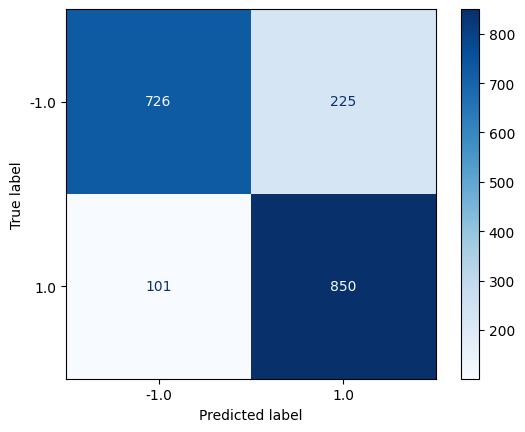

In [163]:
def adabbost(X_train,y_train, n_estimators=500, max_depth=3):
    ab_model = AdaBoostClassifier(n_estimators=20,max_depth=max_depth, criterion="gini")
    ab_model.fit(X_train, y_train)
    return ab_model

ab_model = adabbost(X_train,y_train, best_n_estimators,best_max_depth)
#Make Predictions
y_pred = ab_model.predict(X_test)
#Evaluate
evaluate_model(y_test,y_pred,"ab_model")

#### <u>Interpretation</u>

* <b>Precision</b> – Of all predictions labeled as positive (e.g., LLM-generated), 83% were correct → The model still avoids many false alarms but has room for improvement.
* <b>Recall</b> – Of all actual positive samples, 83% were correctly identified → The model captures most LLM-generated samples, though some are missed.
* <b>F1 Score</b> – A balanced measure of precision and recall: 83%, indicating a solid but not perfect model.
* <b>Accuracy</b> – 83% overall classification correctness.
* 306 misclassifications in total (225 false positives + 101 false negatives).
* The model performs reasonably well at detecting LLM-generated code — 101 real LLM samples were missed out of 951.
* There are 225 cases where the model mislabels human-written code as LLM-generated.
* Overall, the model is fairly accurate and balanced, though there is noticeable room for improvement compared to previous performance.
* When compared to sklearn’s AdaBoost, we observe similar performance when SAMME is used, but noticeably lower scores in our custom model compared to sklearn's model when SAMME.R is used.
* This is because SAMME.R leverages the confidence (probabilities) of the weak learners rather than just their hard predictions, enabling more refined updates and often better performance.
* Our custom implementation only supports hard-label voting (as in SAMME), and cannot benefit from these probability-based refinements, explaining the performance gap.

<hr>

## <u>Models - preformance overview ans summery</u>

MODEL EVALUATION RESULTS
                       Accuracy  Precision  Recall  F1 Score
Sklearn Random Forest    0.9695     0.9706  0.9695    0.9695
Sklearn Adabbost         0.9642     0.9661  0.9642    0.9642
Custom Random Forest     0.9579     0.9602  0.9579    0.9579
Sklearn Decision Tree    0.9532     0.9565  0.9532    0.9531
Custom Decision Tree     0.9516     0.9545  0.9516    0.9516
Custom Adabbost          0.8286     0.8343  0.8286    0.8279


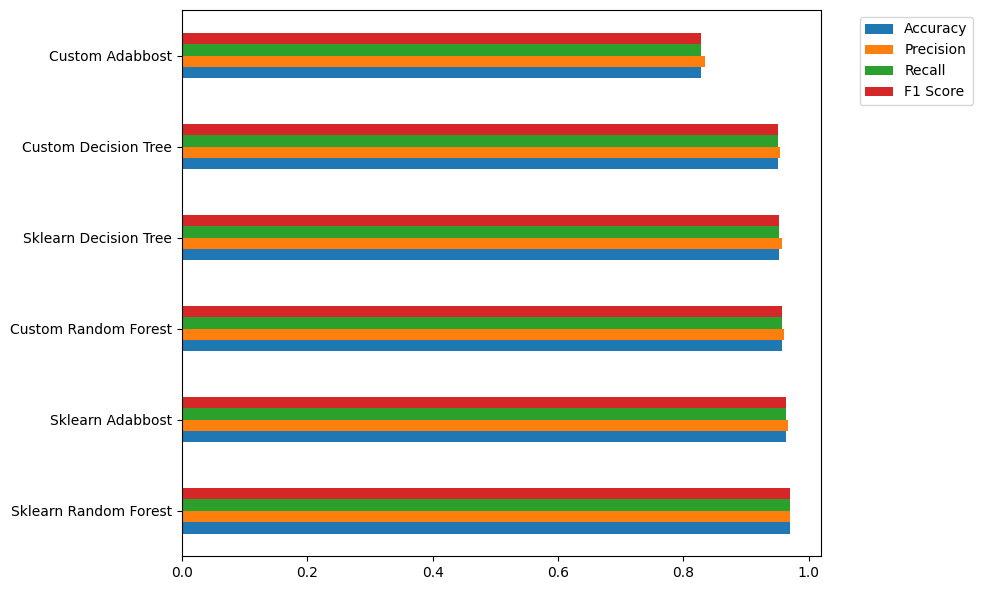

In [164]:
# Create DataFrame for table display
df = pd.DataFrame(evaluations).T
df = df.round(4)  # Round to 2 decimal places for better readability

# Rename index for better display
model_names = {
    'sk_dt_model': 'Sklearn Decision Tree',
    'dt_model': 'Custom Decision Tree', 
    'sk_rf_model': 'Sklearn Random Forest',
    'rf_model': 'Custom Random Forest',
    'sk_ab_model': 'Sklearn Adabbost',
    'ab_model': 'Custom Adabbost',
}

df.index = [model_names[idx] for idx in df.index]
df_sorted = df.sort_values('Accuracy', ascending=False)
print("="*70)
print("MODEL EVALUATION RESULTS")
print("="*70)
print(df_sorted)
print("="*70)

#plot
df_sorted.plot.barh(figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### <u>Model Evaluation Summary</u>

#### Top Performer
- **Sklearn Random Forest** is the top-performing model across all metrics:
  - **Accuracy**: 96.95%
  - **Precision**: 97.06%
  - **Recall**: 96.95%
  - **F1 Score**: 96.95%
  - It provides highly accurate and consistent classification, with excellent balance between precision and recall.

#### Strong Contenders
- **Sklearn AdaBoost** and **Sklearn Decision Tree** follow closely:
  - **Sklearn AdaBoost**:
    - Accuracy: 96.42%
    - F1 Score: 96.42%
    - Shows the benefit of boosting over a single decision tree.
  - **Sklearn Decision Tree**:
    - Accuracy: 95.32%
    - F1 Score: 95.31%
    - A strong standalone model with competitive performance.

#### Custom Models vs. Sklearn
- **Custom Random Forest** and **Custom Decision Tree** perform well but slightly under sklearn counterparts:
  - **Custom Random Forest**:
    - Accuracy: 95.79%
    - F1 Score: 95.79%
  - **Custom Decision Tree**:
    - Accuracy: 95.16%
    - F1 Score: 95.16%
  - The ~1% gap suggests effective implementation but room for further optimization (e.g., better feature splits, randomness handling).

- **Custom AdaBoost** shows **significantly weaker results**:
  - **Accuracy**: 82.86%
  - **F1 Score**: 82.79%
  - Likely due to limitations in the boosting strategy (e.g., using `SAMME` instead of `SAMME.R`, lack of probabilistic weighting, or instability in weak learners).

#### Overall Insights
- **Sklearn ensemble models** (Random Forest and AdaBoost) clearly outperform all others in consistency and effectiveness.
- **Custom models** offer good results, with trees and forests close to sklearn, vali


<hr>

## <u>Feature importance</u>
* This was done with sklearn's built-in functions in order to further understand the subject
* we did not implement custom function since it was not project's and course academic material focuse

In [227]:
feature_names = X_train.columns

for name, model in [('sk_dt_model', sk_dt_model), ('sk_rf_model', sk_rf_model), ('sk_ab_model', sk_ab_model)]:
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    print(f"\n{name} Top Features:")
    for idx in sorted_indices[:10]:  # top 10
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")



sk_dt_model Top Features:
snake_case_count: 0.1619
avg_line_length: 0.1478
misspelling_ratio: 0.1258
num_assignments: 0.1180
num_blank_lines: 0.0797
num_lines: 0.0457
ends_with_space: 0.0456
indent_uses_spaces: 0.0453
comment_ratio: 0.0385
max_indent_depth: 0.0324

sk_rf_model Top Features:
avg_line_length: 0.1150
num_blank_lines: 0.1121
snake_case_count: 0.0979
num_assignments: 0.0806
num_lines: 0.0732
misspelling_ratio: 0.0569
comment_ratio: 0.0558
num_functions: 0.0532
indent_uses_spaces: 0.0518
num_conditionals: 0.0436

sk_ab_model Top Features:
avg_line_length: 0.3479
num_lines: 0.1081
num_assignments: 0.0842
indent_uses_spaces: 0.0812
num_blank_lines: 0.0649
max_indent_depth: 0.0508
num_conditionals: 0.0473
num_loops: 0.0466
snake_case_count: 0.0421
num_prints: 0.0361


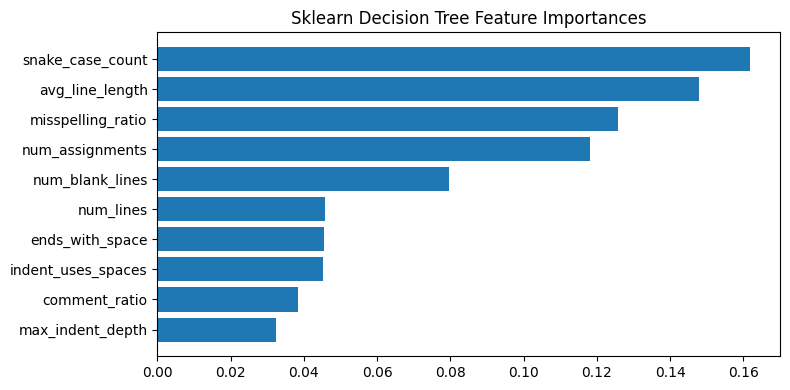

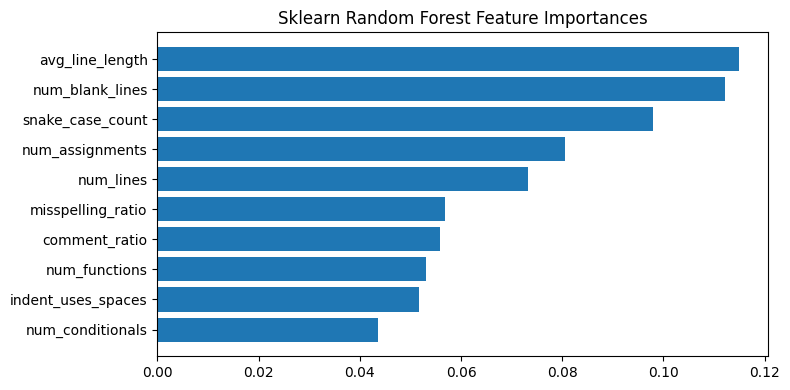

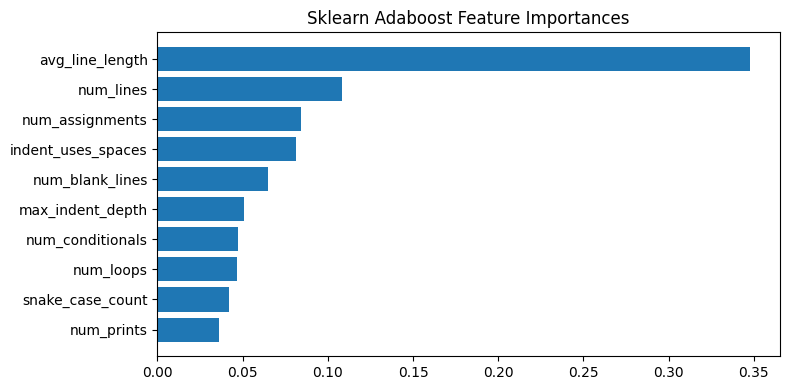

In [230]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 4))
    plt.title(f"{model_name} Feature Importances")
    plt.barh(np.array(feature_names)[indices[:10]][::-1], importances[indices[:10]][::-1])
    plt.tight_layout()
    plt.show()

plot_feature_importance(sk_dt_model, X_train.columns, "Sklearn Decision Tree")
plot_feature_importance(sk_rf_model, X_train.columns, "Sklearn Random Forest")
plot_feature_importance(sk_ab_model, X_train.columns, "Sklearn Adaboost")


### Feature Importance Summary (Top 10 Features per Model)

| Feature              | sk_dt_model | sk_rf_model | sk_ab_model |
|----------------------|-------------|-------------|-------------|
| avg_line_length      | 0.1478      | 0.1150      | 0.3479      |
| snake_case_count     | 0.1619      | 0.0979      | 0.0421      |
| misspelling_ratio    | 0.1258      | 0.0569      | -           |
| num_assignments      | 0.1180      | 0.0806      | 0.0842      |
| num_blank_lines      | 0.0797      | 0.1121      | 0.0649      |
| num_lines            | 0.0457      | 0.0732      | 0.1081      |
| ends_with_space      | 0.0456      | -           | -           |
| indent_uses_spaces   | 0.0453      | 0.0518      | 0.0812      |
| comment_ratio        | 0.0385      | 0.0558      | -           |
| max_indent_depth     | 0.0324      | -           | 0.0508      

### recall correlations:
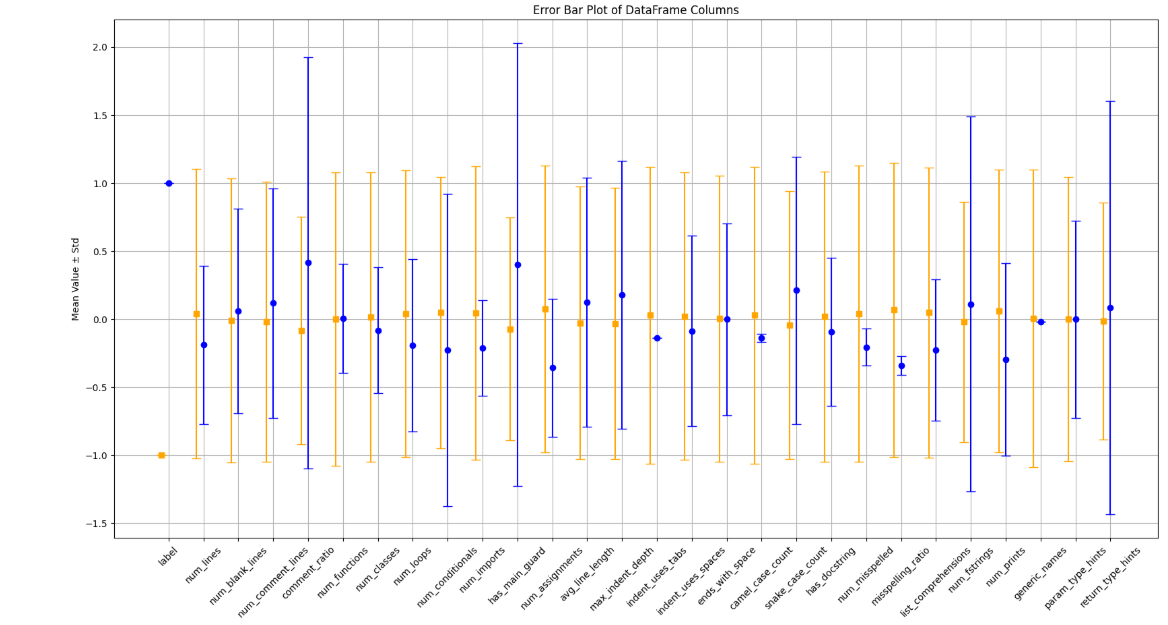


### Key Takeaways

- `avg_line_length` is the most influential feature across all models, and **LLM-generated code tends to have longer lines** than human-written code.
- `snake_case_count` is higher in Human code, suggesting **Humans prefer more consistent naming styles**.
- `misspelling_ratio` is also higher in Human code, possibly due to the fact that humans aren't 100% consistent in their work.
- `num_assignments` and `num_blank_lines` are both higher in LLM code, hinting at **more verbosity** or **clearer spacing conventions**.
- Features like `max_indent_depth`, `num_loops`, and `num_conditionals` show mixed patterns but tend to have a slightlyhigher variance in Human code.


<hr>

## <u>Testing our models with unseen data</u>
* We used llama3_1_8b LLM (src:  [https://huggingface.co/spaces/ysharma/Chat_with_Meta_llama3_1_8b](https://huggingface.co/spaces/ysharma/Chat_with_Meta_llama3_1_8b))
*  to answer a python coding question from [https://prepbytes.com/blog/top-20-coding-questions-for-basic-python-programming/](https://prepbytes.com/blog/top-20-coding-questions-for-basic-python-programming/)
* the question -  Write a python program to find a fibonacci of a number
* human answer was also obtain from that site

In [232]:
def predict_code_src(path_to_code, dt_model, rf_model, ab_model, sk_dt_model, sk_rf_model, sk_ab_model, evaluations):
    # Read and clean code
    with open(path_to_code, "r", encoding='utf-8-sig') as f:
        code = f.read().lstrip('\ufeff')
    
    print(f"Analyzing code from: {path_to_code}:")
    print("-----------------------------------------------")
    print(code)
    print("-----------------------------------------------\n\n")
    
    # Extract features
    features = extract_features_from_code(code)
    X_new = pd.DataFrame([features])
    
    # Match training features
    training_features = [col for col in clean_df.columns if col != 'label']
    for col in training_features:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[training_features]
    
    # Normalize with training stats
    temp_df_features, _ = extract_features_df(human_vs_generated_df, 'code')
    original_mean = temp_df_features[training_features].mean()
    original_std = temp_df_features[training_features].std()
    X_new_normalized = ((X_new - original_mean) / original_std).fillna(0)
    
    # Mapping
    res_dict = {1: "LLM", -1: "Human"}
    predictions = {}
    
    # Get model predictions
    predictions['dt_model'] = dt_model.predict(X_new_normalized)[0]
    predictions['sk_dt_model'] = sk_dt_model.predict(X_new_normalized)[0]
    predictions['rf_model'] = rf_model.predict(X_new_normalized)[0]
    predictions['sk_rf_model'] = sk_rf_model.predict(X_new_normalized)[0]
    
    ab_pred_custom = ab_model.predict(X_new_normalized)
    predictions['ab_model'] = int(ab_pred_custom[0].item()) if hasattr(ab_pred_custom[0], 'item') else int(ab_pred_custom[0])
    
    predictions['sk_ab_model'] = sk_ab_model.predict(X_new_normalized)[0]
    
    # Print individual model predictions
    print("Model Predictions:")
    for model_name, pred in predictions.items():
        print(f"{model_name}: {res_dict[pred]}")
    
    # Weighted vote
    total_accuracy = sum(model_eval['Accuracy'] for model_eval in evaluations.values())
    weighted_sum = 0
    total_weight = 0
    for model_name, pred in predictions.items():
        weight = evaluations[model_name]['Accuracy']/total_accuracy
        weighted_sum += pred * weight
        total_weight += weight
    
    final_prediction = 1 if weighted_sum >= 0 else -1
    print(f"\nFinal Weighted Prediction: {res_dict[final_prediction]}")


In [222]:
predict_code_src("./LLM_test.py", dt_model, rf_model, ab_model, sk_dt_model, sk_rf_model, sk_ab_model, evaluations)

Analyzing code from: ./LLM_test.py:
-----------------------------------------------
def fibonacci_recursive(n):
    """
    Calculate the nth Fibonacci number recursively.

    Args:
        n (int): The position of the Fibonacci number.

    Returns:
        int: The nth Fibonacci number.
    """
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

# Example usage
n = 10
print(f"The {n}th Fibonacci number is: {fibonacci_recursive(n)}")
-----------------------------------------------


Model Predictions:
dt_model: LLM
sk_dt_model: LLM
rf_model: LLM
sk_rf_model: LLM
ab_model: LLM
sk_ab_model: Human

Final Weighted Prediction: LLM


In [223]:
predict_code_src("./HUMAN_test.py", dt_model, rf_model, ab_model, sk_dt_model, sk_rf_model, sk_ab_model, evaluations)

Analyzing code from: ./HUMAN_test.py:
-----------------------------------------------
nterms = int(input("How many terms? "))
n1, n2 = 0, 1
count = 0

if nterms <= 0:
   print("Please enter a positive integer")
elif nterms == 1:
   print("Fibonacci sequence upto",nterms,":")
   print(n1)
else:
   print("Fibonacci sequence:")
   while count < nterms:
       print(n1)
       nth = n1 + n2
       n1 = n2
       n2 = nth
       count += 1
-----------------------------------------------


Model Predictions:
dt_model: Human
sk_dt_model: Human
rf_model: Human
sk_rf_model: Human
ab_model: Human
sk_ab_model: Human

Final Weighted Prediction: Human


<hr>

## <u>Conclusions</u>

<span style="font-size:16px">

This project explored the feasibility of distinguishing between human-written and LLM-generated Python code using a variety of machine learning classifiers—both handcrafted and scikit-learn based—on the AIGCodeSet dataset. 
All models preformed nicely but SKlearn random forest was slightly better than the rest, reaching 97% accuracy.

Several important constraints impacted the scope of this work:

- The model was trained on code dated approximately 6–12 months prior.
- Outputs from recent LLMs like ChatGPT, Claude, and Cohere were not included in the dataset.
- The dataset focused only on short Python snippets, limiting generalizability.
- Non-English code and LLM-edited or post-processed code were not represented.
  
Despite these limitations, this work demonstrates meaningful progress toward identifying machine-generated code and offers useful insights for practical applications in academic integrity, technical hiring, and digital content verification. 

Additionally, the model's insights into the key features indicative of LLM-generated code can be used to craft prompts that avoid stylistic patterns likely to reveal LLM generation. * Alternatively, these insights can guide manual post-generation edits that counteract the identified distinguishing features, making the code less detectable as machine-generated.

Future work should expand on this foundation by:

- Incorporating more recent and diverse model outputs.
- Exploring deeper code semantics and structural features.
- Addressing adversarial or obfuscated examples.

The insights derived here may also serve as a basis for crafting or editing code to either reveal or conceal signs of LLM involvement, depending on the use case.

Ultimately, as LLM capabilities continue to improve, so too must the methods for detecting their fingerprints—making this a dynamic and essential area for continued research.
</span>